# OUTDATED, the examples moved to the manual
## See https://empymod.readthedocs.io/en/stable/examples

----

# DC apparent resistivity, dipole-dipole configuration


There are various DC sounding layouts, the most common ones being Schlumberger, Wenner, pole-pole, pole-dipole, and **dipole-dipole**, at which we have a look here.

Dipole-dipole layout as shown in figure 8.32 in Kearey et al. (2002):
![title](figures/Fig_from_8-32.jpg)

The apparent resistivity $\rho_a$ of the *plotting point* is then calculated with
$$\rho_a = \frac{V}{I} \pi na(n+1)(n+2)\ ,$$
where $V$ is measured Voltage, $I$ is source strength, $a$ is dipole length, and $n$ is the factor of source-receiver separation.

#### References

**Kearey, P., M. Brooks, and I. Hill, 2002**, An introduction to geophysical exploration, 3rd ed.: Blackwell Scientific Publications, ISBN: 0 632 04929 4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import empymod as epm

In [2]:
# Plot-style adjustments
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100

## Calculate $\boldsymbol{\rho_a}$
First we define a function to calculate apparent resistivity for a given model and given source and receivers.

In [3]:
def calc_appres(depth, res, a, n, srcpts=1, recpts=1, verb=1):
    """Return apparent resistivity for dipole-dipole DC measurement
    
        rho_a = V/I pi a n (n+1) (n+2).
    
    Returns die apparent resistivity due to:
    - Electric source, inline (y = 0 m).
    - Source of 1 A strength.
    - Source and receiver are located at the air-interface.
    - Source is centered at x = 0 m.
    
    Note: DC response can be obtained by either t->infinity s or f->0 Hz.
          f = 0 Hz is much faster, as there is no Fourier transform involved
          and only a single frequency has to be calculated. By default,
          the minimum frequency in empymod is 1e-20 Hz. The difference between
          the signals for 1e-20 Hz and 0 Hz is very small.
          
    For more explanation regarding input parameters see `empymod.model`.
          
    Parameters
    ----------
    depth : Absolute depths of layer interfaces, without air-interface.
    res : Resistivities of the layers, one more than depths (lower HS).
    a : Dipole length.
    n : Separation factors.
    srcpts, recpts : If < 3, bipoles are approximated as dipoles.
    verb : Verbosity.
          
    Returns
    -------
    rho_a : Apparent resistivity.
    AB2 : Src/rec-midpoints
    
    """

    # Get offsets between src-midpoint and rec-midpoint, AB
    AB = (n+1)*a
    
    # Collect model, putting source and receiver slightly (1e-3 m) into the ground.
    model = {
        'src': [-a/2, a/2, 0, 0, 1e-3, 1e-3],
        'rec': [AB-a/2, AB+a/2, AB*0, AB*0, 1e-3, 1e-3],
        'depth': np.r_[0, np.array(depth, ndmin=1)],
        'freqtime': 1e-20,  # Smaller f would be set to 1e-20 be empymod.
        'verb': verb,       # Setting it to 1e-20 avoids warning-message.
        'res': np.r_[2e14, np.array(res, ndmin=1)],
        'strength': 1       # So it is NOT normalized to 1 m src/rec.
    }
    
    return np.real(epm.bipole(**model))*np.pi*a*n*(n+1)*(n+2), AB/2

## Plot-function
Second we create a plot-function, which includes the call to `calc_appres`, to use for a couple of different models.

In [4]:
def plotit(depth, a, n, res1, res2, res3, title):
    """Call `calc_appres` and plot result."""
    
    # Calculate the three different models
    rho1, AB2 = calc_appres(depth, res1, a, n)
    rho2, _ = calc_appres(depth, res2, a, n)
    rho3, _ = calc_appres(depth, res3, a, n)

    # Create figure
    fig = plt.figure(figsize=(8,6), facecolor='w')

    # Plot curves
    plt.loglog(AB2, rho1, label='Case 1')
    plt.plot(AB2, rho2, label='Case 2')
    plt.plot(AB2, rho3, label='Case 3')
    
    # Legend, labels
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel('AB/2 (m)')
    plt.ylabel(r'Apparent resistivity $\rho_a (\Omega\,$m)')  
    
    plt.show()

## Model 1: 2 layers


layer   | depth (m)     | resistivity ($\Omega\,$m) 
--------|---------------|--------------------
air     | $-\infty$ - 0 | 2e14                
layer 1 | 0 - 50        | 10    
layer 2 | 50 - $\infty$ | 100 / 10 / 1                  

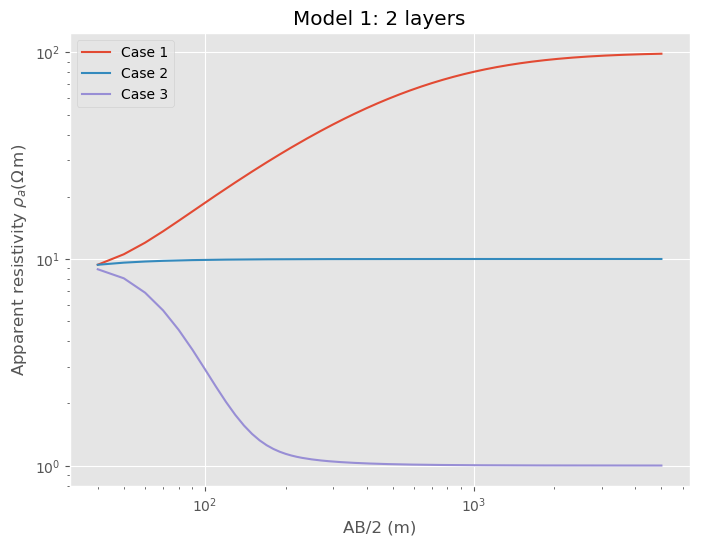

In [5]:
plotit(
    50,                 # Depth
    20,                 # a (src- and rec-lengths)
    np.arange(3, 500),  # n
    [10, 100],          # Case 1
    [10,  10],          # Case 2
    [10,   1],          # Case 3
    'Model 1: 2 layers')

## Model 2: layer embedded in background


layer   | depth (m)      | resistivity ($\Omega\,$m) 
--------|----------------|--------------------
air     | $-\infty$ - 0  | 2e14                
layer 1 | 0 - 50         | 10             
layer 2 | 50 - 500       | 100 / 10 / 1    
layer 3 | 500 - $\infty$ | 10                  

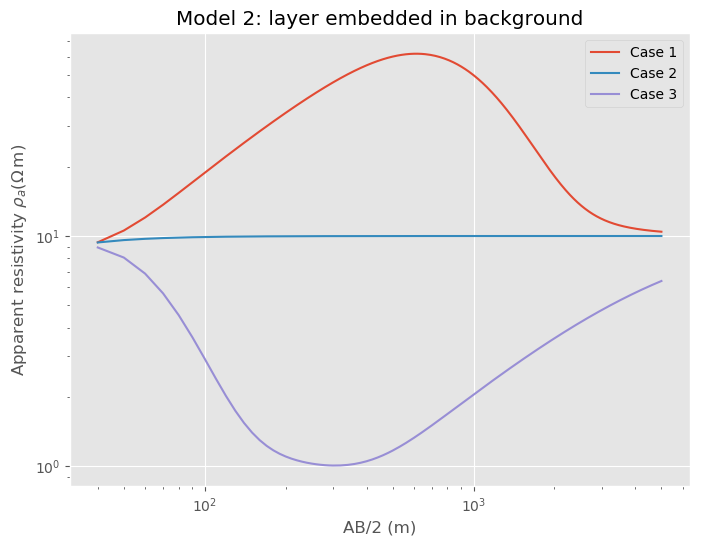

In [6]:
plotit(
    [50, 500],          # Depth
    20,                 # a (src- and rec-lengths)
    np.arange(3, 500),  # n
    [10, 100, 10],      # Case 1
    [10,  10, 10],      # Case 2
    [10,   1, 10],      # Case 3
    'Model 2: layer embedded in background')

## Model 3: 3 layers


layer   | depth (m)      | resistivity ($\Omega\,$m) 
--------|----------------|--------------------
air     | $-\infty$ - 0  | 2e14                
layer 1 | 0 - 50         | 10             
layer 2 | 50 - 500       | 100 / 10 / 1    
layer 3 | 500 - $\infty$ | 1000 / 10 / 0.1                  

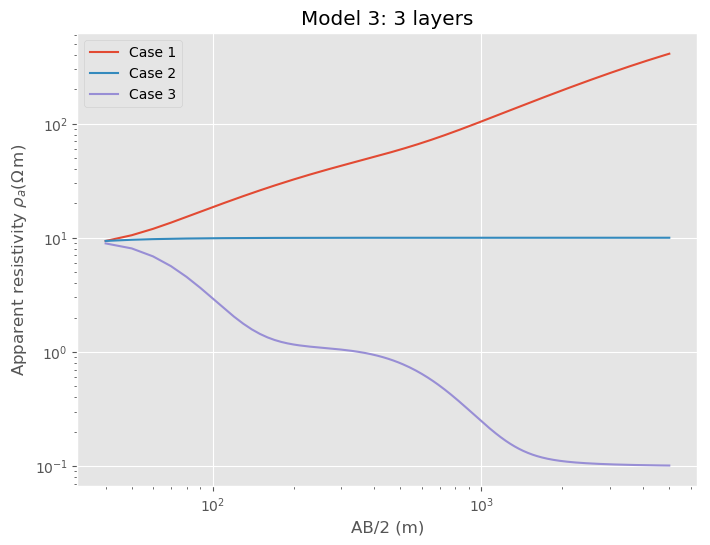

In [7]:
plotit(
    [50, 500],          # Depth
    20,                 # a (src- and rec-lengths)
    np.arange(3, 500),  # n
    [10, 100, 1000],    # Case 1
    [10,  10,   10],    # Case 2
    [10,   1,    0.1],  # Case 3
    'Model 3: 3 layers')

In [8]:
epm.versions('HTML')